# Cell Line Analysis

We sought to validate the Ras classifier trained on TCGA pan-cancer data by generating predictions on cell line data. A good classifier should generalize to predicting Ras status in other samples. We apply the classifier on two datasets:

1. [GSE94937](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE94937) from [Kim et al. 2017](http://doi.org/10.1016/j.cels.2017.08.002)
  * Illumina NextSeq 5000 of Human Small Airway Epithelial Cells expressing KRAS G12V and wild-type KRAS
2. [Cancer Cell Line Encyclopedia (CCLE)](https://software.broadinstitute.org/software/cprg/?q=node/11) Gene Expression data.
  * 737 cell lines with matching gene expression and mutation calls
  * Pharmacologic profiling of 24 drugs over 504 cell lines
  
These data were accessed via publicly available resources with help from links in the [UCSD-CCAL Onco-GPS github repository](https://github.com/UCSD-CCAL/onco-gps-paper-analysis)

In [2]:
import os
import numpy as np
import pandas as pd
from decimal import Decimal
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare
from sklearn.preprocessing import StandardScaler
from Bio.SeqUtils import IUPACData

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg

In [3]:
# Store protein change dictionary
aa = IUPACData.protein_letters_1to3_extended

In [4]:
%matplotlib inline

## Load PI3K_gain Classifier Coefficients

In [5]:
classifier_file = os.path.join('..', 'classifiers', 'ERBB2_PIK3CA_KRAS_AKT1', 'classifier_summary.txt')
with open(classifier_file) as class_fh:
    for line in class_fh:
        line = line.strip().split('\t')
        if line[0] == 'Coefficients:':
            all_coef_df = pd.read_table(os.path.join('..', line[1]), index_col=0)

# Only non-zero coefficients contribute to model performance
coef_df = all_coef_df[all_coef_df['abs'] > 0]
print(coef_df.shape)
coef_df.head(10)

(301, 3)


,feature,weight,abs
5497,MFN1,0.096137,0.096137
2031,PIK3R3,0.087689,0.087689
344,LASP1,0.087670,0.087670
3994,GRB7,0.074477,0.074477
3884,PGAP3,0.070023,0.070023
6757,NAAA,-0.067662,0.067662
2793,CABC1,-0.064753,0.064753
5244,STARD3,0.064621,0.064621
3172,MRPS35,0.063482,0.063482
3724,C17orf37,0.060451,0.060451


## Part 2: CCLE

Note - This data was also retrieved from the Onco-GPS paper analysis repository

In [6]:
#ccle_file_name = os.path.join('..', '..', 'onco-gps-paper-analysis', 'data',
#                              'rpkm__gene_x_ccle_cellline.gct')
ccle_file_name = os.path.join('..','data','ccle_rnaseq_genes_rpkm_20180929_mod.gct')
ccle_df = pd.read_csv(ccle_file_name, skiprows=2, index_col=0)
print(ccle_df.shape)
ccle_df = ccle_df.drop_duplicates(subset='Description',keep = 'first')
ccle_df.head()

(56202, 1020)


,Description,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Name,,,,,,,,,,,,,,,,,,,,,
DDX11L1,DDX11L1,0.053448,0.043078,0.037956,0.028313,0.009377,0.004012,0.017452,0.013608,0.018103,...,0.180119,0.102898,0.354700,0.418945,0.270819,0.096412,0.116833,0.025481,0.124122,0.030062
WASH7P,WASH7P,5.752560,4.261040,3.100480,3.079090,3.994940,3.356750,2.569410,3.025490,2.787330,...,5.420360,2.323580,5.666570,2.795510,2.432770,3.703760,3.163270,3.983540,4.601320,4.563500
MIR1302-11,MIR1302-11,0.039576,0.011961,0.031618,0.031446,0.020831,0.053476,0.029075,0.040305,0.040212,...,0.244510,0.114286,0.472748,0.572692,0.481268,0.091785,0.070780,0.011320,0.127255,0.055648
FAM138A,FAM138A,0.037400,0.022608,0.013280,0.026416,0.006562,0.022461,0.018318,0.006348,0.012667,...,0.196060,0.164578,0.384714,0.285641,0.363853,0.077102,0.104051,0.000000,0.133623,0.028048
OR4G4P,OR4G4P,0.000000,0.019401,0.025642,0.008501,0.008447,0.000000,0.007860,0.016343,0.000000,...,0.144213,0.039722,0.239619,0.135462,0.097575,0.037218,0.095669,0.036722,0.051601,0.018052


In [7]:
# Subset to common genes in the classifier and CCLE data
common_genes = list(set(coef_df['feature']) & set(ccle_df.index))
common_ccle_coef = coef_df[coef_df['feature'].isin(common_genes)]
print(common_ccle_coef.shape)
common_ccle_coef.head()

(289, 3)


,feature,weight,abs
5497,MFN1,0.096137,0.096137
2031,PIK3R3,0.087689,0.087689
344,LASP1,0.087670,0.087670
3994,GRB7,0.074477,0.074477
3884,PGAP3,0.070023,0.070023


In [8]:
ccle_df = ccle_df.loc[common_ccle_coef['feature'], ccle_df.columns[1:]]
ccle_df.head()

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Name,,,,,,,,,,,,,,,,,,,,,
MFN1,17.97990,11.79370,9.80215,7.98314,7.000680,6.93426,8.302100,13.772800,10.37780,6.844000,...,9.078280,11.44410,16.67330,13.30060,10.818600,9.514120,14.191200,12.868600,23.3665,14.3656
PIK3R3,9.25843,4.83508,1.69842,4.50486,8.560180,2.73800,1.005470,4.991270,3.89730,12.442100,...,0.777115,3.32173,2.06800,1.01442,2.050920,7.305420,6.659750,12.245400,23.9449,32.9145
LASP1,43.07200,39.89530,53.44110,31.99880,97.803600,147.40100,95.274800,31.854200,97.70670,23.216100,...,44.435200,139.30600,36.16780,85.30900,37.045200,93.121600,77.683800,47.733100,28.4888,377.2450
GRB7,9.37537,17.47750,16.92790,11.13410,0.075793,9.82622,0.093199,0.115228,11.27680,0.056547,...,0.473720,8.02399,3.80374,2.64814,14.146700,0.862748,0.508946,0.055901,10.7048,218.0380
PGAP3,5.76702,3.26199,3.45212,3.91196,1.646300,2.64953,2.414570,2.182810,5.78247,2.368490,...,3.965820,10.24980,4.81944,2.59941,0.591144,4.088240,4.016190,10.522700,10.0363,323.4960


In [9]:
scaled_fit = StandardScaler().fit(ccle_df.T)
ccle_df = pd.DataFrame(scaled_fit.transform(ccle_df.T),
                            index=ccle_df.columns,
                            columns=ccle_df.index)

print(ccle_df.shape)
ccle_df.head()

(1019, 289)


Name,MFN1,PIK3R3,LASP1,GRB7,PGAP3,NAAA,STARD3,MRPS35,ACTL6A,TTC17,...,TMEM164,FAM32A,SRRM1,INSR,PPP1R3B,MGAT4A,EBPL,DDHD2,ARHGAP8,ARHGAP12
22RV1_PROSTATE,1.032956,0.467350,-0.453181,-0.030043,-0.118152,2.198144,-0.270842,2.173606,-0.061261,0.372871,...,-0.047132,-0.990447,-0.289350,0.295792,-0.320896,-0.325682,0.263228,0.287485,0.354803,-0.292374
2313287_STOMACH,-0.142760,-0.147860,-0.526315,0.141222,-0.188026,-0.900891,-0.334505,1.036183,-0.434714,0.755835,...,2.883026,-1.138328,-0.151228,-0.253229,-0.624047,-0.352718,0.547344,0.388898,0.217034,4.631226
253JBV_URINARY_TRACT,-0.521264,-0.584114,-0.214463,0.129605,-0.182723,-0.241336,-0.134833,-0.127824,-0.006052,-1.152805,...,0.671415,-0.790640,0.147569,-0.586944,0.492446,-0.398434,-0.177832,-0.761498,-0.716895,-0.760644
253J_URINARY_TRACT,-0.866975,-0.193788,-0.708109,0.007134,-0.169896,-0.562578,-0.161178,-0.213826,-0.867280,-0.988579,...,0.907965,0.412313,-0.193082,-0.191303,-0.514191,0.198915,-0.461181,-1.018329,-0.598537,-0.397928
42MGBA_CENTRAL_NERVOUS_SYSTEM,-1.053697,0.370236,0.806854,-0.226620,-0.233093,0.080229,-0.211802,-0.733054,-1.125867,-0.983712,...,-0.613738,0.246011,0.895663,-0.783933,-0.453879,-0.549486,-1.292309,-0.357339,-0.729530,-0.509043


In [10]:
ccle_df = ccle_df.T
print(ccle_df.shape)
#ccle_df = ccle_df2.drop_duplicates(subset = ccle_df2.index, keep = 'first')
ccle_df.head()

(289, 1019)


,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Name,,,,,,,,,,,,,,,,,,,,,
MFN1,1.032956,-0.142760,-0.521264,-0.866975,-1.053697,-1.066320,-0.806355,0.233377,-0.411859,-1.083474,...,-0.658839,-0.209203,0.784631,0.143633,-0.328083,-0.576005,0.312896,0.061530,2.056705,0.346041
PIK3R3,0.467350,-0.147860,-0.584114,-0.193788,0.370236,-0.439526,-0.680491,-0.126136,-0.278288,0.910142,...,-0.712251,-0.358340,-0.532712,-0.679246,-0.535087,0.195721,0.105920,0.882784,2.509978,3.757490
LASP1,-0.453181,-0.526315,-0.214463,-0.708109,0.806854,1.948688,0.748635,-0.711438,0.804623,-0.910305,...,-0.421798,1.762325,-0.612130,0.519202,-0.591931,0.699064,0.343654,-0.345873,-0.788917,7.240173
GRB7,-0.030043,0.141222,0.129605,0.007134,-0.226620,-0.020513,-0.226252,-0.225787,0.010150,-0.227027,...,-0.218209,-0.058609,-0.147818,-0.172245,0.070815,-0.209985,-0.217464,-0.227041,-0.001941,4.380733
PGAP3,-0.118152,-0.188026,-0.182723,-0.169896,-0.233093,-0.205110,-0.211663,-0.218128,-0.117721,-0.212949,...,-0.168394,0.006888,-0.144583,-0.206508,-0.262525,-0.164979,-0.166989,0.014500,0.000933,8.744406


In [11]:
# Get the weights ready for applying the classifier
apply_weights = pd.DataFrame(common_ccle_coef['weight'])
apply_weights.index = common_ccle_coef.feature
print(apply_weights.shape)
apply_weights.head()

(289, 1)


,weight
feature,
MFN1,0.096137
PIK3R3,0.087689
LASP1,0.087670
GRB7,0.074477
PGAP3,0.070023


In [12]:
# Apply a logit transform [y = 1/(1+e^(-wX))] to output probabilities
result_ccle = apply_weights.T.dot(ccle_df)
result_ccle = 1 / (1 + np.exp(-1 * result_ccle))

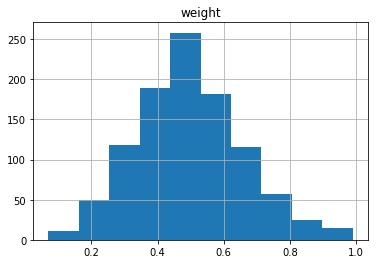

In [13]:
# Distribution of predictions of the Ras Classifier applied to CCLE data
result_ccle.T.hist();

In [14]:
# Load CCLE Mutation Data
#ccle_mut_file_name = os.path.join('..', '..', 'onco-gps-paper-analysis', 'data', 
#                                  'mutation__gene_x_ccle_cellline.gct')
ccle_mut_file_name = os.path.join('..','data','CCLE_MUT_CNA_AMP_DEL_binary_Revealer.gct')
ccle_all_mut_df = pd.read_table(ccle_mut_file_name, skiprows=2, index_col=0)
print(ccle_all_mut_df.shape)
ccle_all_mut_df.head()

(48270, 1031)


,Description,DMS53_LUNG,SW1116_LARGE_INTESTINE,NCIH1694_LUNG,P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,UMUC3_URINARY_TRACT,HOS_BONE,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,PLB985_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SKNO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HOP62_LUNG,EKVX_LUNG,OVCAR5_OVARY,UO31_KIDNEY,SF268_CENTRAL_NERVOUS_SYSTEM,SF539_CENTRAL_NERVOUS_SYSTEM,SNB75_CENTRAL_NERVOUS_SYSTEM,HOP92_LUNG
Name,,,,,,,,,,,,,,,,,,,,,
AKT3_MUT,AKT3_MUT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABI1_MUT,ABI1_MUT,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CDH2_MUT,CDH2_MUT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC100130776_MUT,LOC100130776_MUT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HDAC6_MUT,HDAC6_MUT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Load CCLE Variant Data
#ccle_maf_file = 'https://data.broadinstitute.org/ccle/CCLE_DepMap_18Q1_maf_20180207.txt'
ccle_maf_file = os.path.join('..','data','CCLE_DepMap_18Q1_maf_20180207.txt')
ccle_maf_df = pd.read_table(ccle_maf_file, index_col=15)
print(ccle_maf_df.shape)
ccle_maf_df.head(2)

/home/nagampv/anaconda3/envs/pancancer/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,25,26,27,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1175706, 31)


,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,AGRN,375790,37,1,979072,979072,+,Silent,SNP,A,...,False,0,NaN,27:24,9:10,9:12,104:20,NaN,NaN,15:13
22RV1_PROSTATE,ATAD3A,55210,37,1,1459233,1459233,+,Silent,SNP,A,...,False,0,0.000008,29:49,33:40,30:38,315:308,NaN,NaN,17:31


In [15]:
# Identify all cell lines with mutations in pi3k_gain genes, also subset pten mutant samples
pi3k_genes = ['AKT1_MUT', 'PIK3CA_MUT', 'KRAS_MUT', 'ERBB2_MUT']
pi3k_status = ccle_all_mut_df.loc[pi3k_genes, :].T.apply(max, axis=1)

# BRAF mutations do not contribute to Ras status in this case
ccle_mut_df = (
    ccle_all_mut_df.loc[pi3k_genes + ['BRAF_MUT'], :].T
    .assign(pi3k_status=pi3k_status).drop(['Description'])
    )
print(ccle_mut_df.shape)
ccle_mut_df.head(5)

(1030, 6)


Name,AKT1_MUT,PIK3CA_MUT,KRAS_MUT,ERBB2_MUT,BRAF_MUT,pi3k_status
DMS53_LUNG,0,0,0,0,0,0
SW1116_LARGE_INTESTINE,0,0,1,0,0,1
NCIH1694_LUNG,0,0,0,0,0,0
P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0,0,0,0,0,0
HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0,0,0,0,0,0


In [16]:
# Join classifier scores with mutation status
ccle_full_df = ccle_mut_df.join(result_ccle.T).dropna()
ccle_full_df = ccle_full_df.assign(sample_name = ccle_full_df.index)
ccle_full_df = ccle_full_df.sort_values(by='weight', ascending=False)
ccle_full_df.index.name = 'cell_line'
print(ccle_full_df.shape)
ccle_full_df.head(5)

(913, 8)


,AKT1_MUT,PIK3CA_MUT,KRAS_MUT,ERBB2_MUT,BRAF_MUT,pi3k_status,weight,sample_name
cell_line,,,,,,,,
UACC893_BREAST,0,1,0,0,0,1,0.989817,UACC893_BREAST
CALU3_LUNG,0,0,0,0,0,0,0.987227,CALU3_LUNG
OE19_OESOPHAGUS,0,0,0,0,0,0,0.978839,OE19_OESOPHAGUS
ZR7530_BREAST,0,0,0,0,0,0,0.978471,ZR7530_BREAST
BT474_BREAST,0,1,0,0,0,1,0.969544,BT474_BREAST


In [17]:
# Write CCLE Scores to file
ccle_scores_file = os.path.join('..', 'results', 'ccle_pi3k_gain_BRAF_classifier_scores.tsv')
ccle_full_df.to_csv(ccle_scores_file, sep='\t')

In [18]:
# Use Seaborn for the 2nd plot
sns.set(style="whitegrid")
sns.set_context("paper", rc={"font.size":11, "axes.titlesize":11, "axes.labelsize":16,
                             'xtick.labelsize':11, 'ytick.labelsize':11})

### Perform a t-test on classifier weights across groups

In [20]:
# pi3k mutant vs. pi3k wildtype
pi3k_mutant = ccle_full_df[ccle_full_df['pi3k_status'] == 1]
pi3k_wt = ccle_full_df[ccle_full_df['pi3k_status'] == 0]

# Also interested in BRAF status within Ras wildtype samples
BRAF_mutant = pi3k_wt[pi3k_wt['BRAF_MUT'] == 1]
BRAF_wt = pi3k_wt[pi3k_wt['BRAF_MUT'] == 0]

# Also interested in PTEN status within PI3k gain_mutant samples
BRAF_mutant_2 = pi3k_mutant[pi3k_mutant['BRAF_MUT'] == 1]
BRAF_wt_2 = pi3k_mutant[pi3k_mutant['BRAF_MUT'] == 0]

# Output t-test results
t_results_pi3k = ttest_ind(a = pi3k_mutant['weight'],
                          b = pi3k_wt['weight'], equal_var = False)
print('pi3k Status:')
print(t_results_pi3k)

t_results_BRAF = ttest_ind(a = BRAF_mutant['weight'],
                           b = BRAF_wt['weight'], equal_var = False)
print('\nBRAF Status in PI3K Wild-Type Samples:')
print(t_results_BRAF)

t_results_BRAF_2 = ttest_ind(a = BRAF_mutant_2['weight'],
                           b = BRAF_wt_2['weight'], equal_var = False)
print('\nBRAF Status in PI3K mutant-Type Samples:')
print(t_results_BRAF_2)


pi3k Status:
Ttest_indResult(statistic=7.591881252558332, pvalue=2.2345338238603483e-13)

BRAF Status in PI3K Wild-Type Samples:
Ttest_indResult(statistic=-2.989722005505215, pvalue=0.003575401233788251)

BRAF Status in PI3K mutant-Type Samples:
Ttest_indResult(statistic=3.3057259301818624, pvalue=0.0024243017201062696)


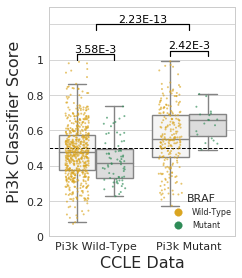

In [21]:
# Plot Results
x1, x2 = 0, 1
x3, x4 = -0.2, 0.2
x5, x6 = 0.8, 1.2
y1, y2,y3, h = 1.17, 1.0,1.02, 0.03


plt.rcParams['figure.figsize']=(3.5, 4)
ax = sns.boxplot(x="pi3k_status", y="weight", data=ccle_full_df,
                 hue='BRAF_MUT', palette = {0: "whitesmoke", 1: 'gainsboro'},
                 fliersize=0)
ax = sns.stripplot(x='pi3k_status', y='weight', hue='BRAF_MUT',
                   data=ccle_full_df, 
                   dodge=True, edgecolor='gray',
                   palette = {1: "seagreen", 0: 'goldenrod'},
                   jitter=0.25, size=2, alpha=0.65)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], ['Wild-Type', 'Mutant'], bbox_to_anchor=(.63, 0.2), loc=2, borderaxespad=0.)
l.set_title("BRAF")
ax.axes.set_ylim(0, 1.3)
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, ''])
ax.set_xticklabels(['Pi3k Wild-Type', 'Pi3k Mutant'])
ax.set_ylabel('Pi3k Classifier Score')
ax.set_xlabel('CCLE Data')
ax.legend
plt.axhline(0.5, color='black', linestyle='dashed', linewidth=1)


# Add PI3K T-Test Results
plt.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1.2, c='black')
plt.text(.5, y1+h, "{:.2E}".format(Decimal(t_results_pi3k.pvalue)),
         ha='center', va='bottom', color="black")

# Add BRAF t-test results
plt.plot([x3, x3, x4, x4], [y2, y2+h, y2+h, y2], lw=1.2, c='black')
plt.text(0, y2+h, "{:.2E}".format(Decimal(t_results_BRAF.pvalue)),
         ha='center', va='bottom', color="black")

# Add BRAF t-test results
plt.plot([x5, x5, x6, x6], [y3, y3+h, y3+h, y3], lw=1.2, c='black')
plt.text(1, y3+h, "{:.2E}".format(Decimal(t_results_BRAF_2.pvalue)),
         ha='center', va='bottom', color="black")

plt.tight_layout()
ccle_fig_file = os.path.join('..', 'figures', 'cell_line', 'ccle_pi3k_wild_mut_BRAF_predictions.pdf')
plt.savefig(ccle_fig_file)

### What percentage of correct classifications in CCLE data?

In [22]:
# Assign a label to what the predictions are given classifier scores
ccle_full_df = ccle_full_df.assign(predictions = 'wild-type')
ccle_full_df.loc[ccle_full_df['weight'] > 0.5, 'predictions'] = 'mutant'

In [23]:
# Stratify cell lines based on predictions and ground truth status
positive_pi3k_predictions_ccle = ccle_full_df[ccle_full_df['weight'] > 0.5]
negative_pi3k_predictions_ccle = ccle_full_df[ccle_full_df['weight'] <= 0.5]

positive_pi3k_lines_ccle = ccle_full_df[ccle_full_df['pi3k_status'] == 1]
negative_pi3k_lines_ccle = ccle_full_df[ccle_full_df['pi3k_status'] == 0]

In [24]:
# Of wild-type Ras cell lines, how many are predicted correctly?
# True Negative Rate, Specificity
negative_pi3k_lines_ccle['predictions'].value_counts()

wild-type    398
mutant       270
Name: predictions, dtype: int64

In [25]:
# Of mutated Ras cell lines, how many are predicted correctly?
# True Positive Rate (TPR), Recall, Sensitivity
positive_pi3k_lines_ccle['predictions'].value_counts()

mutant       170
wild-type     75
Name: predictions, dtype: int64

In [26]:
# Of the wild-type predictions, how many are actually wild-type?
# Negative Predictive Value (NPV)
neg_ccle_results = negative_pi3k_predictions_ccle['pi3k_status'].value_counts()
true_neg = neg_ccle_results[0]
predicted_condition_neg = neg_ccle_results.sum()

print('{} out of {} Pi3k wild-type predictions '
      'are true ({:.1f}%)'.format(true_neg, predicted_condition_neg,
                                  true_neg * 100 / predicted_condition_neg))

398 out of 473 Pi3k wild-type predictions are true (84.1%)


In [27]:
# Of the mutated predictions, how many are actually mutated?
# Positive Predictive Value (PPV) -or- precision
pos_ccle_results = positive_pi3k_predictions_ccle['pi3k_status'].value_counts()
false_pos, true_pos = pos_ccle_results
predicted_condition_pos = pos_ccle_results.sum()

print('{} out of {} Pi3k mutation predictions '
      'are true ({:.1f}%)'.format(true_pos, predicted_condition_pos,
                                  true_pos * 100 / predicted_condition_pos))

170 out of 440 Pi3k mutation predictions are true (38.6%)


In [28]:
total_correct = true_pos + true_neg
print('{} of {} Total cell lines '
      'predicted correctly ({:.1f}%)'.format(total_correct, ccle_full_df.shape[0],
                                             total_correct * 100 / ccle_full_df.shape[0]))

568 of 913 Total cell lines predicted correctly (62.2%)


In [29]:
# Of the False positives, how many are BRAF mutant?
wt_pi3k_braf_ccle = positive_pi3k_predictions_ccle[positive_pi3k_predictions_ccle['pi3k_status'] == 0]
braf_neg, braf_pos = wt_pi3k_braf_ccle['BRAF_MUT'].value_counts()

print('{} of {} total false positives '
      'have BRAF mutations ({:.1f}%)'.format(braf_pos, false_pos,
                                             braf_pos * 100 / false_pos))

17 of 270 total false positives have BRAF mutations (6.3%)


In [30]:
# If include BRAF mutations, how many correct
correct_braf = wt_pi3k_braf_ccle['BRAF_MUT'].value_counts()[1]
true_pos_with_braf = true_pos + correct_braf
print('Including BRAF mutants, {} of {} PI3K mutation predictions '
      'have pi3k pathway mutations ({:.1f}%)'.format(true_pos_with_braf,
                                                    predicted_condition_pos,
                                                    true_pos_with_braf * 100 / predicted_condition_pos))

Including BRAF mutants, 187 of 440 PI3K mutation predictions have pi3k pathway mutations (42.5%)


In [31]:
print('Of the false positives, there are {} BRAF mutated cell lines '
      'and {} BRAF wild-type cell lines'.format(braf_pos, braf_neg))

Of the false positives, there are 17 BRAF mutated cell lines and 253 BRAF wild-type cell lines


In [32]:
total_braf_wildtype, total_braf_mut = ccle_full_df['BRAF_MUT'].value_counts()
print('In all of CCLE, there are {} BRAF mutated cell lines '
      'and {} BRAF wild-type cell lines'.format(total_braf_mut, total_braf_wildtype))

In all of CCLE, there are 87 BRAF mutated cell lines and 826 BRAF wild-type cell lines


## What Ras mutations are identified in False Negatives?

**Variant level predictions in the CCLE**

In [35]:
# How many MAF tumors also have CCLE and mutation data?
len(set(ccle_full_df.index).intersection(set(ccle_maf_df.index)))

913

In [36]:
# Of the false negaves, what RAS mutations do they harbor?
false_negatives_df = negative_pi3k_predictions_ccle.query('pi3k_status == 1')
common_neg_ccle_samples = set(ccle_maf_df.index).intersection(set(false_negatives_df.index))
false_neg_maf_df = ccle_maf_df.loc[list(common_neg_ccle_samples), :]

In [37]:
# What about true positives?
true_positives_df = positive_pi3k_predictions_ccle[positive_pi3k_predictions_ccle['pi3k_status'] == 1]
common_pos_ccle_samples = set(ccle_maf_df.index).intersection(set(true_positives_df.index))
true_pos_maf = ccle_maf_df.loc[list(common_pos_ccle_samples), :]

In [38]:
# Subset to only Ras genes 'AKT1_MUT', 'PIK3CA_MUT', 'KRAS_MUT', 'ERBB2_MUT'
false_neg_ras = false_neg_maf_df.query('Hugo_Symbol in ["KRAS", "AKT1", "ERBB2", "PIK3CA"]')
tru_pos_ras = true_pos_maf.query('Hugo_Symbol in ["KRAS", "AKT1", "ERBB2", "PIK3CA"]')

In [39]:
# Remove duplicate cell-lines. Assume 1 cosmic variant supercedes lack of cosmic
false_neg_dup = false_neg_ras.groupby('Tumor_Sample_Barcode')['isCOSMIChotspot']

cosmic_false_neg = (
    false_neg_dup.value_counts()
    .reset_index(name='count')
    .sort_values(by='isCOSMIChotspot')
    .drop_duplicates(subset='Tumor_Sample_Barcode', keep='last')
)

n_false_neg_cosmic = cosmic_false_neg['isCOSMIChotspot'].value_counts()[1]
n_false_neg_obs = cosmic_false_neg['isCOSMIChotspot'].shape[0]

In [40]:
# What is the proportion of COSMIC variant (True) to non-COSMIC variant (False)
print(cosmic_false_neg['isCOSMIChotspot'].value_counts())
cosmic_false_neg['isCOSMIChotspot'].value_counts(normalize=True)

True     59
False    15
Name: isCOSMIChotspot, dtype: int64


True     0.797297
False    0.202703
Name: isCOSMIChotspot, dtype: float64

In [41]:
# Remove duplicate cell-lines. Assume 1 cosmic variant supercedes lack of cosmic
tru_pos_dup = tru_pos_ras.groupby('Tumor_Sample_Barcode')['isCOSMIChotspot']

cosmic_true_pos = (
    tru_pos_dup.value_counts()
    .reset_index(name='count')
    .sort_values(by='isCOSMIChotspot')
    .drop_duplicates(subset='Tumor_Sample_Barcode', keep='last')
)

n_true_pos_cosmic = cosmic_true_pos['isCOSMIChotspot'].value_counts()[1]
n_tru_pos_obs = cosmic_true_pos['isCOSMIChotspot'].shape[0]

In [42]:
print(cosmic_true_pos['isCOSMIChotspot'].value_counts())
cosmic_true_pos['isCOSMIChotspot'].value_counts(normalize=True)

True     147
False     23
Name: isCOSMIChotspot, dtype: int64


True     0.864706
False    0.135294
Name: isCOSMIChotspot, dtype: float64

In [44]:
# Test if the proportions of observed COSMIC variants are significantly different
# between true positives and false negatives. All of these samples have Ras mutations.
# The question is asking if the proportion of Ras variants annotated in the COSMIC
# database is lower in False negative tumors (those the classifier predicted as
# Ras wild-type) than in True positive tumors
cosmic_prop_chi = proportions_chisquare(count = [n_false_neg_cosmic, n_true_pos_cosmic],
                                        nobs = [n_false_neg_obs, n_tru_pos_obs])

print('Chi Square = {}, p value = {}'.format(cosmic_prop_chi[0], cosmic_prop_chi[1]))
print('There is a no significant difference in the expected proportion of COSMIC variants.')

Chi Square = 1.7817635604283832, p value = 0.1819329204145474
There is a no significant difference in the expected proportion of COSMIC variants.


### Add CCLE Variant Scores (nucleotide and amino acid) to Supplementary Data Files

In [45]:
# Load TCGA PanCanAtlas Core Ras Pathway genes
pi3k_genes_file = os.path.join('..', 'data', 'pi3k_genes.csv')
pi3k_core_df = pd.read_csv(pi3k_genes_file)
pi3k_core_df.head()

,genes,og_tsg
0,PIK3CA,OG
1,PIK3CB,OG
2,PIK3R2,OG
3,AKT1,OG
4,AKT2,OG


In [46]:
# Subset MAF file to Ras pathway variants and merge with CCLE classifier scores
pi3k_pathway_genes = pi3k_core_df['genes'].tolist()
all_common_lines = set(ccle_maf_df.index).intersection(set(ccle_full_df.index))

# Subset to common cell lines
subset_maf = ccle_maf_df.loc[list(all_common_lines), :]
subset_maf = (
    subset_maf.query('Hugo_Symbol in @pi3k_pathway_genes')
    .loc[:, ['Hugo_Symbol', 'Protein_Change', 'cDNA_Change']]
    .merge(ccle_full_df, left_index=True, right_index=True)
)

subset_maf.head(3)

,Hugo_Symbol,Protein_Change,cDNA_Change,AKT1_MUT,PIK3CA_MUT,KRAS_MUT,ERBB2_MUT,BRAF_MUT,pi3k_status,weight,sample_name,predictions
A204_SOFT_TISSUE,PIK3CB,p.Y176C,c.527A>G,0,0,0,0,0,0,0.430099,A204_SOFT_TISSUE,wild-type
A204_SOFT_TISSUE,TSC2,p.L764L,c.2292G>A,0,0,0,0,0,0,0.430099,A204_SOFT_TISSUE,wild-type
A204_SOFT_TISSUE,NF1,p.L1274F,c.3820C>T,0,0,0,0,0,0,0.430099,A204_SOFT_TISSUE,wild-type


In [47]:
# Get the mean classifier scores for CCLE nucleotide variants
mean_nuc_data = (
    pd.DataFrame(subset_maf
                 .groupby(['cDNA_Change', 'Hugo_Symbol'])['weight']
                 .mean())
)
mean_nuc_data.columns = ['ccle_mean_weight']
mean_nuc_data = mean_nuc_data.reset_index()

# Get the sd classifier scores for CCLE variants
sd_nuc_data = (
    pd.DataFrame(subset_maf
                 .groupby(['cDNA_Change', 'Hugo_Symbol'])['weight']
                 .std())
)
sd_nuc_data.columns = ['ccle_sd_weight']
sd_nuc_data = sd_nuc_data.reset_index()

# Counts of CCLE variants altering amino acids
count_nuc_data = (
    pd.DataFrame(subset_maf
                 .groupby(['cDNA_Change', 'Hugo_Symbol'])['weight']
                 .count())
)
count_nuc_data.columns = ['ccle_count']
count_nuc_data = count_nuc_data.reset_index()

In [49]:
# Merge protein data
nuc_merge_on = ['Hugo_Symbol', 'cDNA_Change']
nuc_change_df = (
    mean_nuc_data.merge(sd_nuc_data,
                        left_on=nuc_merge_on, right_on=nuc_merge_on)
    .merge(count_nuc_data, left_on=nuc_merge_on, right_on=nuc_merge_on)
)

nuc_change_df.sort_values('ccle_count').tail(5)

,cDNA_Change,Hugo_Symbol,ccle_mean_weight,ccle_sd_weight,ccle_count
858,c.3140A>G,PIK3CA,0.648678,0.178247,20
411,c.181C>A,NRAS,0.510373,0.161022,21
942,c.34G>T,KRAS,0.541869,0.133000,23
962,c.35G>T,KRAS,0.614544,0.158873,33
958,c.35G>A,KRAS,0.626536,0.130691,47


In [50]:
data_s4_file = os.path.join('..', 'classifiers', 'ERBB2_PIK3CA_KRAS_AKT1', 'tables',
                            'nucleotide_mutation_scores.tsv')
data_s4_df = pd.read_table(data_s4_file)
# Merge the CCLE nucleotide scores
data_s4_df = data_s4_df.merge(nuc_change_df, left_on = ['Hugo_Symbol', 'HGVSc'],
                                    right_on = ['Hugo_Symbol', 'cDNA_Change'],
                              how='outer')
updated_data_s4_df = data_s4_df.sort_values(by='count', ascending=False)
updated_data_s4_df.head()
updated_data_s4_file = os.path.join('..', 'classifiers', 'ERBB2_PIK3CA_KRAS_AKT1', 'tables', 'updated_Data_S4.csv')
updated_data_s4_df.to_csv(updated_data_s4_file, sep=',', index=False)

In [51]:
# Get the mean classifier scores for CCLE variants
mean_protein_data = (
    pd.DataFrame(subset_maf
                 .groupby(['Protein_Change', 'Hugo_Symbol'])['weight']
                 .mean())
)
mean_protein_data.columns = ['ccle_mean_weight']
mean_protein_data = mean_protein_data.reset_index()

# Get the sd classifier scores for CCLE variants
sd_protein_data = (
    pd.DataFrame(subset_maf
                 .groupby(['Protein_Change', 'Hugo_Symbol'])['weight']
                 .std())
)
sd_protein_data.columns = ['ccle_sd_weight']
sd_protein_data = sd_protein_data.reset_index()

# Counts of CCLE variants altering amino acids
count_protein_data = (
    pd.DataFrame(subset_maf
                 .groupby(['Protein_Change', 'Hugo_Symbol'])['weight']
                 .count())
)
count_protein_data.columns = ['ccle_count']
count_protein_data = count_protein_data.reset_index()

In [52]:
# Merge protein data
merge_on = ['Hugo_Symbol', 'Protein_Change']
protein_change_df = (
    mean_protein_data.merge(sd_protein_data,
                            left_on=merge_on, right_on=merge_on)
    .merge(count_protein_data, left_on=merge_on, right_on=merge_on)
)

protein_change_df.sort_values('ccle_count').tail(5)

,Protein_Change,Hugo_Symbol,ccle_mean_weight,ccle_sd_weight,ccle_count
358,p.E545K,PIK3CA,0.554342,0.194647,20
1159,p.Q61K,NRAS,0.510373,0.161022,21
446,p.G12C,KRAS,0.541869,0.133000,23
455,p.G12V,KRAS,0.614544,0.158873,33
449,p.G12D,KRAS,0.626536,0.130691,47


In [53]:
# Convert amino acid to 3 letters
protein_convert = [''.join([aa[x] if x in aa.keys() else x for x in y]) 
                   for y in protein_change_df['Protein_Change']]

protein_change_df = protein_change_df.assign(conversion = protein_convert)

In [54]:
data_s5_file = os.path.join('..', 'classifiers', 'ERBB2_PIK3CA_KRAS_AKT1', 'tables',
                            'amino_acid_mutation_scores.tsv')
data_s5_df = pd.read_table(data_s5_file)

# Merge the CCLE protein scores
data_s5_df = data_s5_df.merge(protein_change_df, left_on = ['Hugo_Symbol', 'HGVSp'],
                                    right_on = ['Hugo_Symbol', 'conversion'],
                              how='outer')

# Sort by the total number of mutations observed
updated_data_s5_df = (
    data_s5_df.drop(['Protein_Change'], axis=1).sort_values(by='count', ascending=False)
)

updated_data_s5_file = os.path.join('..', 'classifiers', 'ERBB2_PIK3CA_KRAS_AKT1','tables', 'updated_Data_S5.csv')
updated_data_s5_df.to_csv(updated_data_s5_file, sep=',', index=False)
updated_data_s5_df.head()

,HGVSp,Variant_Classification,Hugo_Symbol,Mean,SD,count,low_CI,high_CI,ccle_mean_weight,ccle_sd_weight,ccle_count,conversion
0,p.Glu545Lys,Missense_Mutation,PIK3CA,0.709914,0.134668,273.0,0.694224,0.726930,0.554342,0.194647,20.0,p.Glu545Lys
1,p.His1047Arg,Missense_Mutation,PIK3CA,0.722902,0.150649,231.0,0.703152,0.741369,0.648678,0.178247,20.0,p.His1047Arg
2,p.Glu542Lys,Missense_Mutation,PIK3CA,0.678922,0.138295,177.0,0.658705,0.698811,0.575551,0.198286,11.0,p.Glu542Lys
3,p.Gly12Asp,Missense_Mutation,KRAS,0.685515,0.126081,171.0,0.664020,0.703034,0.626536,0.130691,47.0,p.Gly12Asp
4,p.Gly12Val,Missense_Mutation,KRAS,0.692915,0.119621,164.0,0.675094,0.711410,0.614544,0.158873,33.0,p.Gly12Val


## CCLE - Pharmacologic Efficacy

Here, we process drug efficacy data on the CCLE dataset. Data obtained from https://portals.broadinstitute.org/ccle/data (Pharmacologic profiling) (signin required).

A processed `.tsv` file is output to be visualized in `scripts/viz/ras_ccle_pharmacology.R`.

In [55]:
# Load in pharmacological results
pharm_file = os.path.join('..', 'data', 'CCLE_NP24.2009_Drug_data_2015.02.24.csv')
pharm_df = pd.read_csv(pharm_file, index_col=0)
pharm_df = pharm_df.assign(tissue = [' '.join(x[1:]) for x in pharm_df.index.str.split('_')])

pharm_full_df = pharm_df.merge(ccle_full_df, left_index=True, right_index=True)
pharm_full_df.head()

,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),...,tissue,AKT1_MUT,PIK3CA_MUT,KRAS_MUT,ERBB2_MUT,BRAF_MUT,pi3k_status,weight,sample_name,predictions
A172_CENTRAL_NERVOUS_SYSTEM,A172,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","-.27,.084,-2.7,-6.1,-6.3,-6.1,-15,-22","5.84,1.59,2.77,5.89,2.43,3.25,4.54,7.73",8,Sigmoid,8.419621,8.000000,...,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.548974,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,Nilotinib,ABL,".0025,.0080,.025,.080,.25,.80,2.53,8","-.75,3.15,9.45,7.81,1.15,4.57,-3.7,-2.1","6.44,3.36,2.34,1.18,1.86,3.21,4.71,6.22",8,Constant,NaN,8.000000,...,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.548974,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,17-AAG,HSP90,".0025,.0080,.025,.080,.25,.80,2.53,8","-4.1,-3.6,-8.3,-13,-49,-67,-67,-71","2.33,.79,1.76,4.40,3.10,2.19,1.71,2.43",8,Sigmoid,0.179408,0.267499,...,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.548974,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,PHA-665752,c-MET,".0025,.0080,.025,.080,.25,.80,2.53,8","-11,-.73,3.40,1.00,.26,5.42,7.48,10.4",".86,7.72,2.80,14.1,6.64,2.25,7.98,6.82",8,Linear,NaN,8.000000,...,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.548974,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,Lapatinib,EGFR,".0025,.0080,.025,.080,.25,.80,2.53,8","3.48,1.18,.20,2.58,-4.6,-2.1,-8.0,-4.2",".91,.27,3.61,4.82,4.66,6.00,3.26,8.81",8,Constant,NaN,8.000000,...,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.548974,A172_CENTRAL_NERVOUS_SYSTEM,mutant


In [56]:
ccle_full_df.head()
ccle_full_df.shape

(913, 9)

In [57]:

common_celllines_pharm = set(ccle_full_df.index).intersection(set(pharm_df.index))
print('There are {} cell lines in common'.format(len(common_celllines_pharm)))

pharm_full_df['Compound'].value_counts()

There are 457 cell lines in common


AZD0530         457
PF2341066       457
TAE684          457
PD-0325901      457
Lapatinib       457
Topotecan       457
TKI258          457
Nutlin-3        457
Paclitaxel      456
Erlotinib       456
AEW541          456
AZD6244         456
LBW242          456
Sorafenib       456
17-AAG          456
PHA-665752      456
Panobinostat    453
ZD-6474         450
PLX4720         450
L-685458        444
RAF265          416
PD-0332991      392
Nilotinib       379
Irinotecan      288
Name: Compound, dtype: int64

In [58]:
pharm_full_df['tissue'].value_counts()

LUNG                                  2016
HAEMATOPOIETIC AND LYMPHOID TISSUE    1585
SKIN                                   865
BREAST                                 653
PANCREAS                               599
OVARY                                  587
CENTRAL NERVOUS SYSTEM                 585
LARGE INTESTINE                        489
ENDOMETRIUM                            458
STOMACH                                396
LIVER                                  388
OESOPHAGUS                             339
URINARY TRACT                          286
SOFT TISSUE                            244
BONE                                   236
AUTONOMIC GANGLIA                      223
PLEURA                                 165
KIDNEY                                 163
UPPER AERODIGESTIVE TRACT              132
THYROID                                 72
PROSTATE                                48
BILIARY TRACT                           24
SALIVARY GLAND                          23
Name: tissu

In [59]:
# What is the cell line tissue representation?
compound_heatmap = pd.pivot_table(pharm_full_df[['tissue', 'Compound']],
                                  columns='tissue', index='Compound',
                                  aggfunc=len)

compound_heatmap = pd.DataFrame(compound_heatmap.unstack()).reset_index()
compound_heatmap.columns = ['tissue', 'Compound', 'count']
compound_heatmap = compound_heatmap.sort_values(by=['tissue', 'Compound'])

/home/nagampv/anaconda3/envs/pancancer/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/nagampv/anaconda3/envs/pancancer/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/nagampv/anaconda3/envs/pancancer/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/home/nagampv/anaconda3/envs/pancancer/lib/python3.6/site-packages/mizani/bounds.py:345: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/home/nagampv/anaconda3/envs/pancancer/lib/python3.6/site-packages/mizani/bounds.py:345: RuntimeWarning: invalid value enco

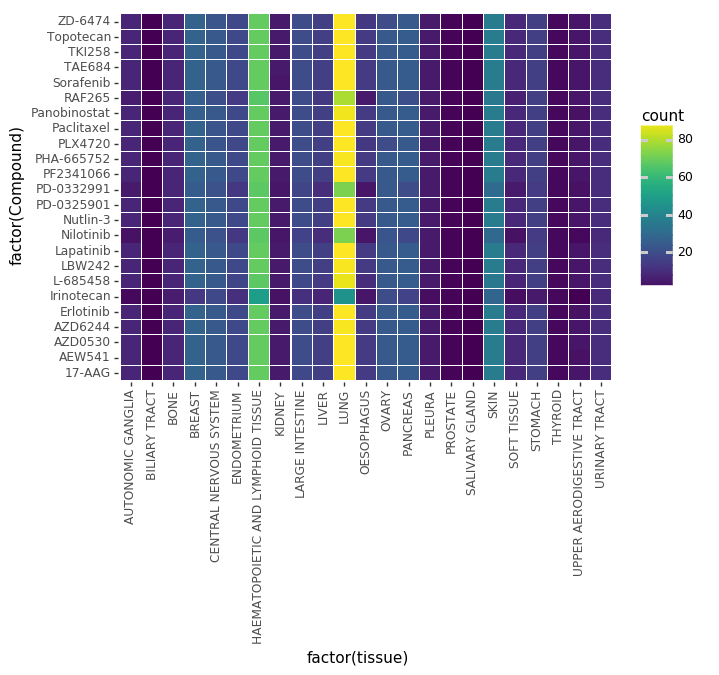

<ggplot: (8747611556237)>

In [60]:
gg.ggplot(compound_heatmap, gg.aes('factor(tissue)', 'factor(Compound)', fill='count')) + \
gg.geom_tile(gg.aes(width=.95, height=.95)) + \
gg.theme(axis_text_x=gg.element_text(rotation=90),
         panel_background=gg.element_rect(fill='white'))

In [61]:
# Write out pharm_full_df to file to plot in ggplot2
# plotnine does not include all the functionality required to create the plot
pharm_file = os.path.join('..', 'data', 'pharmacology_predictions_ERBB2_PIK3CA_KRAS_AKT1_ccle.tsv')
pharm_full_df.to_csv(pharm_file, sep='\t')